In [39]:
pip install kagglehub plotly h5py nbformat>=4.2.0 seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\pantm\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
import h5py
import plotly.graph_objs as go
from plotly.offline import iplot

def _image_output_3d_format(file_path):
    
    with h5py.File(file_path, "r") as points_dataset:        
        digits = []
        index = 10
        
        while index < 20:
            digit = (points_dataset[str(index)]["img"][:], 
                    points_dataset[str(index)]["points"][:], 
                    points_dataset[str(index)].attrs["label"]) 
            digits.append(digit)
            index += 1
            
    x_c = [r[0] for r in digits[0][1]]
    y_c = [r[1] for r in digits[0][1]]
    z_c = [r[2] for r in digits[0][1]]
    
    trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, mode='markers', 
                          marker=dict(size=12, color=z_c, colorscale='Viridis', opacity=0.7))

    data = [trace1]
    layout = go.Layout(height=500, width=600, title="Digit: "+str(digits[0][2]) + " in 3D space")
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

file_path = "C:\\Users\\pantm\\Downloads\\kagglehub\\train_point_clouds.h5"
_image_output_3d_format(file_path)



## Main logic

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read Dataset
custom_path = "C:\\Users\\pantm\\Downloads\\kagglehub\\full_dataset_vectors.h5"

class VolumeProcessor:
    def __init__(self, activation='relu'):
        self.activation = activation

    def apply_activation(self, output):
        switcher = {
            'relu': lambda x: np.maximum(0, x),
            'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
            'tanh': lambda x: np.tanh(x),
            'leaky_relu': lambda x: np.where(x > 0, x, x * 0.01)
        }
        
        if self.activation in switcher:
            return switcher[self.activation](output)
        else:
            raise ValueError(f"Unsupported activation function: {self.activation}")
    
    def pad_volume(self, volume, padding):
        if padding > 0:
            return np.pad(volume, ((0, 0), (padding, padding), (padding, padding), (padding, padding)), mode='constant')
        return volume

    def initialize_kernels(self, num_filters, channels, kernel_size):
        k_d, k_h, k_w = kernel_size
        return np.random.randn(num_filters, channels, k_d, k_h, k_w) / np.sqrt(k_d * k_h * k_w)

    def compute_output_dimensions(self, input_shape, kernel_size, stride, padding):
        channels, depth, height, width = input_shape
        k_d, k_h, k_w = kernel_size

        out_depth = (depth - k_d + 2 * padding) // stride + 1
        out_height = (height - k_h + 2 * padding) // stride + 1
        out_width = (width - k_w + 2 * padding) // stride + 1
        
        return out_depth, out_height, out_width

    def conv3d(self, input_volume, kernel_size, num_filters, stride=1, padding=0):
        channels, depth, height, width = input_volume.shape
        kernels = self.initialize_kernels(num_filters, channels, kernel_size)
        input_volume = self.pad_volume(input_volume, padding)
        
        out_depth, out_height, out_width = self.compute_output_dimensions((channels, depth, height, width), kernel_size, stride, padding)
        output = np.zeros((num_filters, out_depth, out_height, out_width))
        
        for f in range(num_filters):
            for d in range(0, depth - kernel_size[0] + 1, stride):
                for h in range(0, height - kernel_size[1] + 1, stride):
                    for w in range(0, width - kernel_size[2] + 1, stride):
                        output[f, d//stride, h//stride, w//stride] = np.sum(
                            input_volume[:, d:d+kernel_size[0], h:h+kernel_size[1], w:w+kernel_size[2]] * kernels[f]
                        )
                        
        result = self.apply_activation(output)
        return result

    def pool3d(self, input_tensor, pool_size, stride, pooling_type='max'):
        c, d, h, w = input_tensor.shape
        p_d, p_h, p_w = pool_size
        s_d, s_h, s_w = stride

        # Calculate output dimensions
        out_d = (d - p_d) // s_d + 1
        out_h = (h - p_h) // s_h + 1
        out_w = (w - p_w) // s_w + 1

        # Initialize output tensor
        pooled_tensor = np.zeros((c, out_d, out_h, out_w))

        # Perform pooling
        for channel in range(c):
            for z in range(out_d):
                for y in range(out_h):
                    for x in range(out_w):
                        patch = input_tensor[channel, z * s_d:z * s_d + p_d, y * s_h:y * s_h + p_h, x * s_w:x * s_w + p_w]
                        if pooling_type == 'max':
                            pooled_tensor[channel, z, y, x] = np.max(patch)
                        elif pooling_type == 'average':
                            pooled_tensor[channel, z, y, x] = np.mean(patch)
                        else:
                            raise ValueError("Invalid pooling type. Use 'max' or 'average'.")

        return pooled_tensor
    
    def visualize_3D_tensor(self,tensor, title, slice_axis=1, slice_index=None):
        """
        Visualizes a 2D slice of a 3D tensor.
        - tensor: The 3D activation map or input volume.
        - title: The plot title.
        - slice_axis: The axis along which to take the slice (default=1, depth axis).
        - slice_index: The index of the slice (default=None, takes the middle slice).
        """
        tensor = np.squeeze(tensor)  # Remove any singleton dimensions

        if slice_index is None:
            slice_index = tensor.shape[slice_axis] // 2  # Choose middle slice

        # Select the correct slice along the chosen axis
        if slice_axis == 0:  # Depth slice
            slice_2d = tensor[slice_index, :, :]
        elif slice_axis == 1:  # Height slice
            slice_2d = tensor[:, slice_index, :]
        elif slice_axis == 2:  # Width slice
            slice_2d = tensor[:, :, slice_index]
        else:
            raise ValueError("slice_axis must be 0 (depth), 1 (height), or 2 (width).")

        # Plot the slice
        plt.figure(figsize=(6, 6))
        sns.heatmap(slice_2d, cmap="viridis", cbar=True)
        plt.title(title)
        plt.axis("off")
        plt.show()


    def validate_dataset_operation(self,input_volume, output, kernel_size, padding, stride, num_filters):
        """
        Validates the shape of the output of a 3D convolution operation.

        Parameters:
        - input_volume: numpy array of shape (batch, channels, depth, height, width)
        - output: numpy array, the result after convolution
        - kernel_size: tuple (k_d, k_h, k_w)
        - padding: int, amount of zero padding
        - stride: int, stride value
        - num_filters: int, number of filters in the convolution operation

        """
        # Extract dimensions correctly
        channels, depth, height, width = input_volume.shape
        k_d, k_h, k_w = kernel_size

        # Compute expected output dimensions
        out_depth = (depth - k_d + 2 * padding) // stride + 1
        out_height = (height - k_h + 2 * padding) // stride + 1
        out_width = (width - k_w + 2 * padding) // stride + 1

        expected_output_shape = (num_filters, out_depth, out_height, out_width)

        print("Expected output shape:", expected_output_shape)
        print("Actual output shape:", output.shape)

        # Validate shape
        assert output.shape == expected_output_shape, "Output shape doesn't match expected shape!"
        
    def global_pooling(self,input_volume):
        return np.mean(input_volume,axis=(1,2,3))

def read_process_dataset(custom_path):
    with h5py.File(custom_path, 'r') as h5_file:
        X_train = h5_file["X_train"][:]
        #X_test = h5_file["X_test"][:] 
    # Reshape input data to 3D format (batch, depth, height, width, channels)
    xtrain = X_train.reshape(-1, 1,16, 16, 16)
    return xtrain

## Part 1.1: 3D Convolution function 
Implement a function that applies 3D convolution to a given 3D point cloud input. The function should accept an input tensor representing the 3D volume, a kernel size for the convolution filter, stride, padding, number of filters, and a choice of non-linearity activation functions such as ReLU, sigmoid, tanh, or Leaky ReLU. Ensure that your function supports multichannel 3D inputs and correctly computes the output activation maps. Display the input 3D point cloud and the corresponding output activation map, and verify that the output dimensions match
expectations

Expected output shape: (8, 12, 12, 12)
Actual output shape: (8, 12, 12, 12)


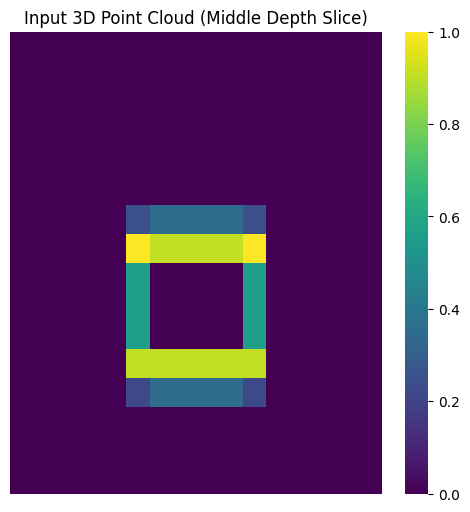

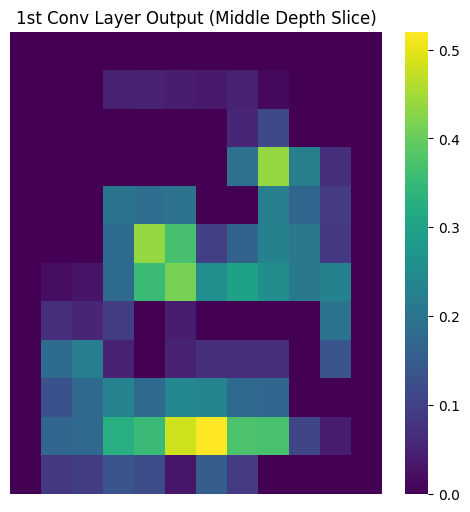

1st Conv Layer - Output Shape: (8, 12, 12, 12)


In [17]:
# # main method
processor = VolumeProcessor(activation='relu')
# read input data
xtrain = read_process_dataset(custom_path)
input_volume = xtrain[0]  # Shape: (16, 16, 16, 1)

padding = 0

# ============ Apply First 3D Convolution Layer ============ #
kernel_size = (5, 5, 5)
num_filters = 8
stride = 1
conv_output = processor.conv3d(input_volume, kernel_size, num_filters,stride,padding)
# ============ Validate the Data ============ #
processor.validate_dataset_operation(input_volume, conv_output, kernel_size, padding, stride, num_filters)
# ============ Visualization ============ #
processor.visualize_3D_tensor(input_volume[0], "Input 3D Point Cloud (Middle Depth Slice)", slice_axis=0)
processor.visualize_3D_tensor(conv_output[0], "1st Conv Layer Output (Middle Depth Slice)", slice_axis=0)


print("1st Conv Layer - Output Shape:", conv_output.shape)  # Expected: (8, 12, 12, 12)


## Part 1.2 3D Pooling function
Implement a function that performs 3D pooling on an activation map
generated by a 3D convolution operation. The function should accept an input tensor, a choice of
pooling operation (Max Pooling or Average Pooling), and stride values. The function should output
the appropriately pooled activation map and verify that the output dimensions are computed
correctly. Compare different pooling strategies by visualizing their effect on feature retention.

Max Pooled Output Shape: (8, 6, 6, 6)
Avg Pooled Output Shape: (8, 6, 6, 6)
Expected output shape: (8, 6, 6, 6)
Actual output shape: (8, 6, 6, 6)
Expected output shape: (8, 6, 6, 6)
Actual output shape: (8, 6, 6, 6)


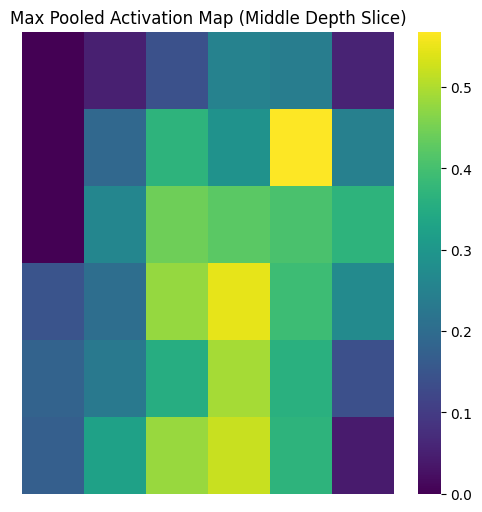

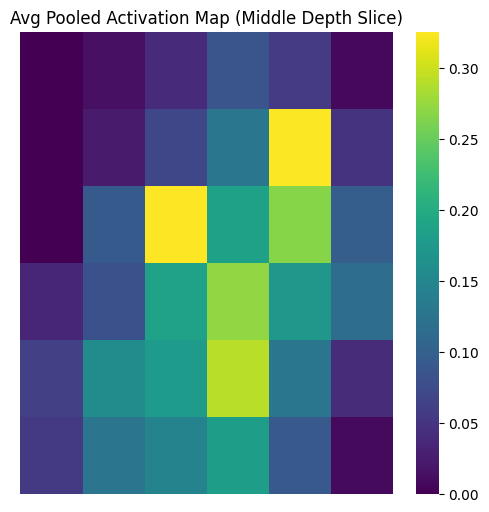

In [18]:
# ============ Apply 3D Max Pooling ============ #
pool_size = (2, 2, 2)
stride = (2, 2, 2)
max_pooled_output = processor.pool3d(conv_output, pool_size, stride, pooling_type='max')
print("Max Pooled Output Shape:", max_pooled_output.shape)  # Expected: (8, 6, 6, 6)
avg_pooled_output = processor.pool3d(conv_output, pool_size, stride, pooling_type='average')
print("Avg Pooled Output Shape:", avg_pooled_output.shape)  # Expected: (8, 6, 6, 6)
#### ============ Validate the Data ============ ####
stride = 2
num_filters=8
processor.validate_dataset_operation(conv_output,max_pooled_output, pool_size, padding, stride, num_filters)
processor.validate_dataset_operation(conv_output,avg_pooled_output, pool_size, padding, stride, num_filters)

#### ============ Visualization ============ ####
processor.visualize_3D_tensor(max_pooled_output[0], "Max Pooled Activation Map (Middle Depth Slice)", slice_axis=0)
processor.visualize_3D_tensor(avg_pooled_output[0], "Avg Pooled Activation Map (Middle Depth Slice)", slice_axis=0)



## Part 1.3 Convolution layer function: 
Implement a function that represents a 3D convolutional layer, which applies multiple 3D convolution filters to an input 3D volume. The function should accept
a 3D input volume, apply multiple convolutional filters with the specified stride, padding, and
activation function, and generate an output activation volume. Display the input, filter kernels,
and resulting feature maps, ensuring that the function produces an output with the correct shape.

2nd Conv Layer - Output Shape: (32, 6, 6, 6)
Expected output shape: (32, 6, 6, 6)
Actual output shape: (32, 6, 6, 6)


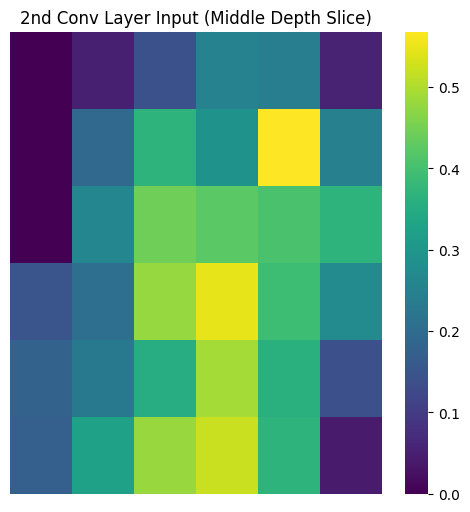

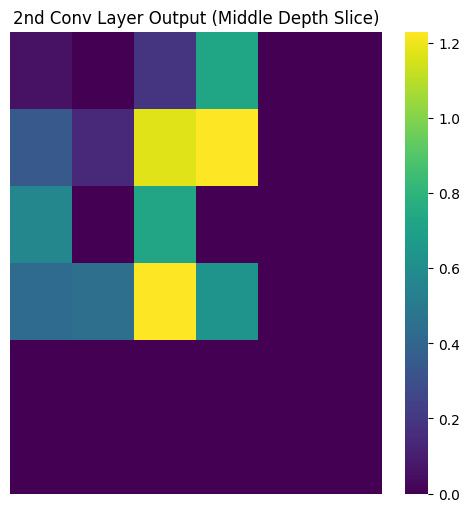

In [19]:
# ============ Apply Second 3D Convolution Layer ============ #
kernel_size = (3, 3, 3)
num_filters = 32
stride = 1
padding = 1
conv_output2 = processor.conv3d(max_pooled_output, kernel_size, num_filters,stride,padding)
print("2nd Conv Layer - Output Shape:", conv_output2.shape)  # Expected: (32, 6, 6, 6)
# ============ Validate the Data ============ #
processor.validate_dataset_operation(max_pooled_output, conv_output2, kernel_size, padding, stride, num_filters)
# ============ Visualization ============ #
processor.visualize_3D_tensor(max_pooled_output[0], "2nd Conv Layer Input (Middle Depth Slice)", slice_axis=0)
processor.visualize_3D_tensor(conv_output2[0], "2nd Conv Layer Output (Middle Depth Slice)", slice_axis=0)




## Part1.4: 3D Pooling layer function: 
Implement a function that applies a 3D pooling layer to a 3D activation map. The function should support both local pooling (Max or Average pooling) and Global Average Pooling (GAP) as a special case. Verify that the pooling layer correctly reduces the spatial dimensions and compare the effects of different pooling strategies

2nd Pooling Layer - Output Shape: (32, 3, 3, 3)
Expected output shape: (32, 3, 3, 3)
Actual output shape: (32, 3, 3, 3)


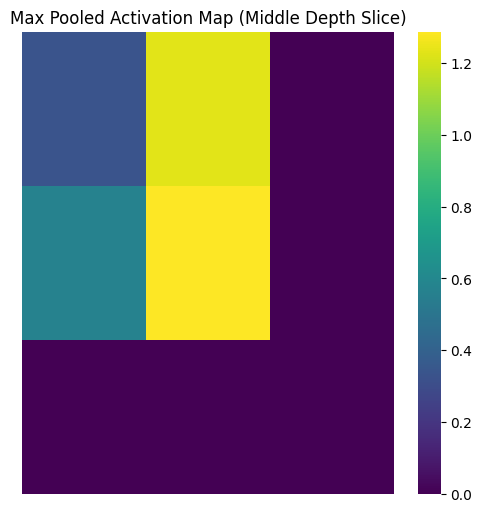

 Global average pool:  [0.32761054 0.27764972 0.15173207 0.02019461 0.33389835 0.07989368
 0.61072776 0.04445473 0.0257951  0.01392431 0.75689966 0.14587223
 0.21756582 0.00566449 0.43435275 0.22563148 0.01549377 0.07740568
 0.26856269 0.8885931  0.12852259 0.14767094 0.22522292 0.29835058
 0.39543941 0.         0.03363287 0.31779285 0.01915497 0.15825886
 0.01720623 0.54458052]
 shape of the global average pool:  (32,)


In [20]:
# ============ Apply Second 3D Max Pool Layer ============ #

pool_size = (2, 2, 2)
stride = (2, 2, 2)
num_filters = 32

padding = 0
max_pooled_output2 = processor.pool3d(conv_output2, pool_size,stride,pooling_type='max')
print("2nd Pooling Layer - Output Shape:", max_pooled_output2.shape)  
# ============ Validate the Data ============ #
stride = 2
processor.validate_dataset_operation(conv_output2,max_pooled_output2, pool_size, padding, stride, num_filters)
# ============ Visualization ============ #
processor.visualize_3D_tensor(max_pooled_output2[0], "Max Pooled Activation Map (Middle Depth Slice)", slice_axis=0)

global_average_pool = processor.global_pooling(max_pooled_output2)
print(" Global average pool: ",global_average_pool)  
print(" shape of the global average pool: ",global_average_pool.shape)  

## Part1.5 and 1.6 Multilayer Perceptron (MLP) function: 
Implement an MLP classifier that takes a flattened vector input from the GAP layer and maps it to a classification output. The function should support multiple hidden layers, allow selection of different activation functions, and output a 10-class vector representing the MNIST digits. The output should be generated with the softmax activation function applied to the final layer

In [22]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights based on xavier initialization strategy
        self.W1 = np.random.randn(self.input_size, self.hidden_size) / np.sqrt(self.input_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) / np.sqrt(self.hidden_size)
        self.b2 = np.zeros((1, self.output_size))

    def relu_func(self, x):
        return np.maximum(0, x)
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    def forward_pass(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu_func(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        a2 = self.softmax(self.z2)
        return a2
    
    def validate_output(self,output):
        assert len(output[0]) == 10, "Output shape doesn't match expected shape!"
        print(" Output prob matches 10 classes: ",len(output[0])==10, )

hidden_size = 64
output_size = 10
ffnn = MLP(global_average_pool.shape[0], hidden_size, output_size)
output_prob = ffnn.forward_pass(global_average_pool)
print(output_prob)
ffnn.validate_output(output_prob)


[[0.07674444 0.08854048 0.10639022 0.10917758 0.08839225 0.0927989
  0.12280822 0.1081427  0.11675732 0.09024789]]
 Output prob matches 10 classes:  True
